In [1]:
library(tidyverse)

library(readxl)
suppressMessages(library(pheatmap))
suppressMessages(library(gridExtra))
suppressMessages(library(grid))


source("../global_variables.R")
source("../theme_ggplot_prevail.R")

INFLAMCAT_FILL_KEY_labs = INFLAMCAT_FILL_KEY
names(INFLAMCAT_FILL_KEY_labs) = gsub("_","\n",names(INFLAMCAT_FILL_KEY_labs))

gene_name_key = read.delim("../0_DATA/gencode.biotype.name.key.tsv")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.5.1     ✔ purrr   1.0.2
✔ tibble  3.2.1     ✔ dplyr   1.1.4
✔ tidyr   1.3.1     ✔ stringr 1.5.1
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



---
## load in data

In [11]:
metadata <- read.csv("../0_DATA/metadata_all.csv")

decon_raw <- read.delim("../0_DATA/PedInflam_2024.01.10_BP.protein_coding.tsv",row.names=1)



#### CONTAINS SENS INFORMATION
# redcap <- read.csv("../../marker_genes/meta_data/cfrna/RedCap-df_merged.csv")
# ucsd_clin <- read.csv("/workdir/cjl332/archive/KD/0_DATA/data/KD_samples sent metadata_090823.csv") %>% mutate(snum = gsub("\\.0","",snum))
# ucsd_clin2 <- read_xlsx("/workdir/cjl332/archive/KD/0_DATA/data/metadata sent to Conor 080323.xlsx")


# ###------------------------------------------
# ### Prep ALT
# ###------------------------------------------
# ucsd_ALT = rbind(ucsd_clin %>% select(snum, palt),
#     ucsd_clin2 %>% select(snum, palt)) %>% unique()

# meta_ALT <- merge(metadata, ucsd_ALT, by.x="PTID", by.y="snum")

# meta_ALT %>% write.csv("meta_ALT.csv", row.names = F)


# ###------------------------------------------
# ### Prep cardiac
# ###------------------------------------------
# redcap_sub = redcap %>% select(PTID, ekg_results,echo_results, echo_impression___1, echo_impression___2, echo_impression___3, echo_impression___4)

# meta_redcap <- merge(metadata, redcap_sub, by="PTID")

# meta_redcap %>% write.csv("./meta_cardiac.csv", row.names = F)



In [3]:
scale_values <- function(x){(x-min(x))/(max(x)-min(x))}

decon <- apply(decon_raw, 2, function(x) scale_values(x))


---
## Create Dot Plot

In [4]:
get_sig_cts <- function(df, group_col, group1, group2){
    output_list = list()
    for (ct in unique(df$celltype)){
        tmp_0 = df %>% filter(celltype == ct) %>% filter(.data[[group_col]] == group1) %>% pull(fraction) %>% as.numeric()
        tmp_1 = df %>% filter(celltype == ct) %>% filter(.data[[group_col]] == group2) %>% pull(fraction) %>% as.numeric()

        res = suppressWarnings(wilcox.test(tmp_0,tmp_1))

        output_list[[ct]] = c(ct, res$p.value)
    }

    output_df <- do.call("rbind",output_list) %>% 
                    data.frame() %>% 
                    rename(ct = X1, pval = X2) %>% 
                    mutate(pval = as.numeric(pval)) %>% 
                    arrange(pval)

    output_df$padj = p.adjust(output_df$pval, method = "BH")

    return(output_df)

}

In [15]:
###------------------------------------------
### Prep ALT
###------------------------------------------
meta_ALT <- read.csv("./meta_ALT.csv")

meta_ALT <- merge(meta_ALT, decon, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(., id.vars = c(colnames(metadata), "palt")) %>%
    rename(celltype = variable, fraction = value) %>% 
    # mutate(GROUP = ifelse(palt > 72, "ALT > 72", "ALT < 72")) %>% 
    # mutate(GROUP = ifelse(palt >= 30, "ALT > 30", "ALT < 30")) %>% 
    mutate(GROUP = case_when (
            palt > 100 ~ "ALT > 100", 
            palt < 40 ~ "ALT < 40",
            .default = NA )) %>% filter(!is.na(GROUP)) %>%
    mutate(COMP = "Liver Damage") %>% 
    select(sample_id, GROUP, COMP, celltype, fraction)


###------------------------------------------
### Prep cardiac
###------------------------------------------
meta_redcap <- read.csv("./meta_cardiac.csv")

t = merge(meta_redcap, decon, by.x="Xsample_id", by.y=0)

t %>% head

meta_redcap <- merge(meta_redcap, decon, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(., id.vars = colnames(meta_redcap)) %>%
    rename(celltype = variable, fraction = value)

cardiac_mdf <- meta_redcap %>% 
    # mutate(cardiac_comp = ifelse( (is.na(echo_results) | echo_results == 1) & (is.na(ekg_results) | ekg_results == 1), "normal\ncardiac function","abnormal\ncardiac function")) %>%
    mutate(cardiac_comp = ifelse( (is.na(echo_results) | echo_results == 1) & (is.na(ekg_results) | ekg_results == 1), "normal","abnormal")) %>%
    filter(diagnosis != "Healthy") %>%
    mutate(GROUP = cardiac_comp) %>% 
    mutate(COMP = "Cardiac Function") %>% 
    select(sample_id, GROUP, COMP, celltype, fraction)


###------------------------------------------
### Prep COVID severity
###------------------------------------------
covid_mdf <- merge(metadata, decon, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(., id.vars = colnames(metadata)) %>%
    rename(celltype = variable, fraction = value)%>% 
    filter(severity %in% c(2,3) & diagnosis == "COVID19") %>% 
    # mutate(severity = ifelse(severity == "2","Moderate\nCOVID-19",ifelse(severity == "3","Severe\nCOVID-19",severity))) %>%
    mutate(severity = ifelse(severity == "2","Moderate",ifelse(severity == "3","Severe",severity))) %>%
    mutate(GROUP = severity) %>%
    mutate(COMP = "COVID-19 Severity") %>% 
    select(sample_id, GROUP, COMP, celltype, fraction)


###------------------------------------------
### Prep Healthy
###------------------------------------------
healthy_mdf <- merge(metadata, decon, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(., id.vars = colnames(metadata)) %>%
    rename(celltype = variable, fraction = value)%>% 
    filter(diagnosis == "Healthy") %>%
    mutate(GROUP = diagnosis) %>%
    mutate(COMP = "Healthy") %>% 
    select(sample_id, GROUP, COMP, celltype, fraction)


###------------------------------------------
### Prep Endothelium
###------------------------------------------
endothelium_mdf <- merge(metadata, decon, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(., id.vars = colnames(metadata)) %>%
    rename(celltype = variable, fraction = value)%>% 
    filter(inflam_cat %in% c("KD","MISC","bacterial_infection","viral_infection")) %>%
    mutate(diagnosis = ifelse(inflam_cat %in% c("KD","MISC"), "KD/MIS-C", "Infection")) %>%
    mutate(GROUP = diagnosis) %>%
    mutate(COMP = "Endothelial Damage") %>% 
    select(sample_id, GROUP, COMP, celltype, fraction)


###------------------------------------------
### MERGE
###------------------------------------------

ALL_MDF <- rbind(meta_ALT, cardiac_mdf, covid_mdf,healthy_mdf,endothelium_mdf)
# ALL_MDF <- rbind(meta_ALT, cardiac_mdf, covid_mdf,healthy_mdf)


,Xsample_id,PTID,sample_id,diagnosis,severity,inflam_cat,ekg_results,echo_results,echo_impression___1,echo_impression___2,⋯,bladder_urothelial_cell,plasmablast,kidney_epithelial_cell,goblet_cell,club_cell_type_i_pneumocyte,pulmonary_ionocyte,pancreatic_pp_cell,pancreatic_delta_cell,duodenum_glandular_cell,thymocyte
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,prevail_cu_cfrna_106,NCOV3390CHOA,prevail_cu_cfrna_106,Inflam,NA,other,2,1,0,0,⋯,0.19359603,0.001244201,0.02343591,0.19387379,0.07940882,0.04417002,0.2638908,0.27531448,0.09586923,0.0290365185
2,prevail_cu_cfrna_108,NCOV3335CHOA,prevail_cu_cfrna_108,MISC,2,MISC,2,1,0,0,⋯,0.86880236,0.012958974,0.81087818,0.23120430,0.24616679,0.69862764,0.7611963,1.00000000,0.19214647,0.1278055969
3,prevail_cu_cfrna_108,NCOV3335CHOA,prevail_cu_cfrna_108,MISC,2,MISC,2,1,0,0,⋯,0.86880236,0.012958974,0.81087818,0.23120430,0.24616679,0.69862764,0.7611963,1.00000000,0.19214647,0.1278055969
4,prevail_cu_cfrna_109,NCOV3389CHOA,prevail_cu_cfrna_109,COVID19,2,viral_infection,NA,2,0,0,⋯,0.07686507,0.000601005,0.03317496,0.09076181,0.12944561,0.04036987,0.3293937,0.08511572,0.31511095,0.0012040813
5,prevail_cu_cfrna_110,NCOV3391CHOA,prevail_cu_cfrna_110,MISC,3,MISC,2,2,0,0,⋯,0.02684813,0.000965324,0.06170459,0.02703719,0.03395275,0.07367220,0.3084979,0.05566762,0.02902571,0.0002707694
6,prevail_cu_cfrna_110,NCOV3391CHOA,prevail_cu_cfrna_110,MISC,3,MISC,2,2,0,0,⋯,0.02684813,0.000965324,0.06170459,0.02703719,0.03395275,0.07367220,0.3084979,0.05566762,0.02902571,0.0002707694


In [16]:
ALL_MDF %>% filter(celltype == "hepatocyte") %>% filter(COMP == "Cardiac Function") %>% pull(GROUP) %>% table()
ALL_MDF %>% filter(celltype == "hepatocyte") %>% filter(COMP == "COVID-19 Severity") %>% pull(GROUP) %>% table()
ALL_MDF %>% filter(celltype == "hepatocyte") %>% filter(COMP == "Endothelial Damage") %>% pull(GROUP) %>% table()
ALL_MDF %>% filter(celltype == "hepatocyte") %>% filter(COMP == "Liver Damage") %>% pull(GROUP) %>% table()
ALL_MDF %>% filter(celltype == "hepatocyte") %>% filter(COMP == "Healthy") %>% pull(GROUP) %>% table()


.
abnormal   normal 
      82       42 

.
Moderate   Severe 
      19       10 

.
Infection  KD/MIS-C 
      146       198 

.
 ALT < 40 ALT > 100 
       83        58 

.
Healthy 
     17 

In [17]:
###------------------------------------------
### SUMMARIZE DATA
###------------------------------------------

CTs = c("hepatocyte","intrahepatic_cholangiocyte",
        "cardiac_muscle_cell","pericyte_cell","kidney_epithelial_cell",
        "club_cell_type_i_pneumocyte", "duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus",
        "endothelial_cell"
        )

newCTs = c("hepatocyte","intrahepatic cholangiocyte",
        "cardiac muscle cell","pericyte cell","kidney epithelial cell",
        "club cell / type i pneumocyte", "duct epithelial cell\nepithelium of bronchus",
        "endothelial cell")

### create summary table        
ALL_SUM <- ALL_MDF %>% 
    group_by(GROUP, COMP, celltype) %>% 
    mutate(fraction = as.numeric(fraction)) %>% 
    summarize(mean = mean(fraction), sd = sd(fraction), n = n(), median = median(fraction))

ALL_SUM <- merge(ALL_SUM, data.frame(celltype = CTs, celltype_label = newCTs), by="celltype") %>% 
    mutate(celltype_label = factor(celltype_label, levels = rev(newCTs))) %>% 
#     mutate(GROUP = factor(GROUP, levels = c('ALT > 72','ALT < 72','abnormal','normal',
#                                             'Severe','Moderate',"KD/MIS-C", "Infection",'Healthy')))%>% 
    # mutate(GROUP = factor(GROUP, levels = c('ALT > 30','ALT < 30','abnormal','normal',
    #                                         'Severe','Moderate',"KD/MIS-C", "Infection",'Healthy')))%>% 
    mutate(GROUP = factor(GROUP, levels = c('ALT > 100','ALT < 40','abnormal','normal',
                                            'Severe','Moderate',"KD/MIS-C", "Infection",'Healthy')))%>% 
    mutate(COMP = factor(COMP, levels = c('Liver Damage','Cardiac Function',
                                            'COVID-19 Severity',"Endothelial Damage",'Healthy')))%>% 

    filter(celltype %in% CTs)



`summarise()` has grouped output by 'GROUP', 'COMP'. You can override using the
`.groups` argument.


In [18]:
cat("LIVER DAMAGE")
# get_sig_cts(ALL_MDF, "GROUP", "ALT > 72", "ALT < 72") %>% 
# get_sig_cts(ALL_MDF, "GROUP", "ALT > 30", "ALT < 30") %>% 
get_sig_cts(ALL_MDF, "GROUP", "ALT > 100", "ALT < 40") %>% 
    filter(ct %in% CTs) %>% 
    mutate(sig = case_when(
            padj <= 0.05 & padj > 0.01 ~ "*",
            padj <= 0.01 & padj > 0.001 ~ "**",
            padj <= 0.001 ~ "***",
            TRUE ~ "ns"
            ))

cat("Cardiac Function")
get_sig_cts(ALL_MDF, "GROUP", "abnormal", "normal") %>% 
    filter(ct %in% CTs) %>% 
    mutate(sig = case_when(
            padj <= 0.05 & padj > 0.01 ~ "*",
            padj <= 0.01 & padj > 0.001 ~ "**",
            pval <= 0.001 ~ "***",
            TRUE ~ "ns"
            ))

cat("COVID-19 Severity")
get_sig_cts(ALL_MDF, "GROUP", "Severe", "Moderate") %>% 
    filter(ct %in% CTs) %>% 
    mutate(sig = case_when(
            padj <= 0.05 & padj > 0.01 ~ "*",
            padj <= 0.01 & padj > 0.001 ~ "**",
            padj <= 0.001 ~ "***",
            TRUE ~ "ns"
            ))

cat("ENDOTHELIAL Damage")
get_sig_cts(ALL_MDF, "GROUP", "KD/MIS-C", "Infection") %>% 
    filter(ct %in% CTs) %>% 
    mutate(sig = case_when(
            padj <= 0.05 & padj > 0.01 ~ "*",
            padj <= 0.01 & padj > 0.001 ~ "**",
            padj <= 0.001 ~ "***",
            TRUE ~ "ns"
            ))

LIVER DAMAGE

,ct,pval,padj,sig
,<chr>,<dbl>,<dbl>,<chr>
hepatocyte,hepatocyte,1.282810e-15,8.081703e-14,***
intrahepatic_cholangiocyte,intrahepatic_cholangiocyte,9.966583e-08,3.139474e-06,***
kidney_epithelial_cell,kidney_epithelial_cell,4.588603e-02,3.212022e-01,ns
endothelial_cell,endothelial_cell,7.193653e-02,3.683086e-01,ns
cardiac_muscle_cell,cardiac_muscle_cell,9.499145e-02,3.740288e-01,ns
club_cell_type_i_pneumocyte,club_cell_type_i_pneumocyte,1.320072e-01,4.366549e-01,ns
duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,4.828091e-01,7.937357e-01,ns
pericyte_cell,pericyte_cell,9.016327e-01,9.414811e-01,ns


Cardiac Function

,ct,pval,padj,sig
,<chr>,<dbl>,<dbl>,<chr>
kidney_epithelial_cell,kidney_epithelial_cell,2.580212e-06,0.0001625533,***
cardiac_muscle_cell,cardiac_muscle_cell,5.708742e-04,0.0040055954,**
intrahepatic_cholangiocyte,intrahepatic_cholangiocyte,6.931119e-04,0.0040055954,**
pericyte_cell,pericyte_cell,2.139012e-03,0.0074865425,**
duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,5.527821e-03,0.0133943364,*
club_cell_type_i_pneumocyte,club_cell_type_i_pneumocyte,6.189104e-03,0.0144412431,*
endothelial_cell,endothelial_cell,2.535131e-02,0.0409521098,*
hepatocyte,hepatocyte,4.624666e-02,0.0647453300,ns


COVID-19 Severity

,ct,pval,padj,sig
,<chr>,<dbl>,<dbl>,<chr>
club_cell_type_i_pneumocyte,club_cell_type_i_pneumocyte,0.0002425361,0.01527977,*
duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,0.0623533388,0.28059002,ns
endothelial_cell,endothelial_cell,0.1945694485,0.45399538,ns
kidney_epithelial_cell,kidney_epithelial_cell,0.1945694485,0.45399538,ns
pericyte_cell,pericyte_cell,0.3076672453,0.52386585,ns
cardiac_muscle_cell,cardiac_muscle_cell,0.3531711667,0.55624459,ns
hepatocyte,hepatocyte,0.5725512868,0.72141462,ns
intrahepatic_cholangiocyte,intrahepatic_cholangiocyte,1.0000000000,1.00000000,ns


ENDOTHELIAL Damage

,ct,pval,padj,sig
,<chr>,<dbl>,<dbl>,<chr>
endothelial_cell,endothelial_cell,3.295961e-06,6.921519e-05,***
kidney_epithelial_cell,kidney_epithelial_cell,9.442106e-04,7.435659e-03,**
intrahepatic_cholangiocyte,intrahepatic_cholangiocyte,1.255938e-02,6.010980e-02,ns
hepatocyte,hepatocyte,4.876923e-02,1.536134e-01,ns
club_cell_type_i_pneumocyte,club_cell_type_i_pneumocyte,5.511712e-02,1.578354e-01,ns
duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,duct_epithelial_cell_serous_cell_of_epithelium_of_bronchus,8.654231e-02,1.816846e-01,ns
cardiac_muscle_cell,cardiac_muscle_cell,1.258333e-01,2.331616e-01,ns
pericyte_cell,pericyte_cell,3.974032e-01,5.007280e-01,ns


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

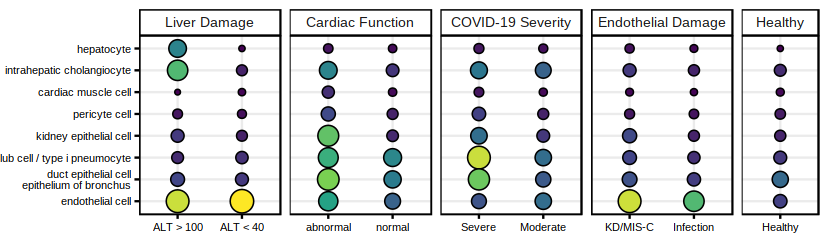

In [19]:
options(repr.plot.height = 2, repr.plot.width = 6.9)

### Plot results
plt = ALL_SUM %>%
    ggplot(aes(x=GROUP, y=celltype_label, size = as.numeric(median), fill = as.numeric(median)))+
    geom_point(pch = 21, color = "black")+
    theme_prevail()+
    theme(legend.position = "none", axis.title = element_blank())+
    labs(size = "Median\nScaled\nFraction", fill = "Median\nScaled\nFraction")+
    scale_fill_viridis_c()+
    scale_fill_viridis_c(guide = "legend")+
    facet_grid(~COMP,  scales = "free_x", space = "free")+
    theme(strip.text.x = element_text(size = 8),
        strip.background = element_rect(fill="white", color="black"))

print(plt)

## Save
HEIGHT = 2
WIDTH = 6.4

pdf(file = paste0("./plots/ALL_damage.comp.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)
print(plt)
dev.off()
    

In [20]:
options(repr.plot.height = 4, repr.plot.width = 4)

suppressMessages(library(gridExtra))

plt_legend <- plt+ 
    theme(legend.position = "right")+
      theme(legend.text = element_text(size = 6),
                             legend.key.size = unit(0.5, "cm"),
                             legend.title = element_text(size = 8),
                             legend.background = element_blank(),
                             legend.position = "right"
                             )

legend <- cowplot::get_legend(plt_legend)

HEIGHT = 1.7
WIDTH = 1

pdf(file = paste0("./plots/ALL_damage.comp.LEGEND.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)
print(grid.arrange(legend))
dev.off()
    

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name              grob
1 1 (1-1,1-1) arrange gtable[guide-box]


png 
  2

In [21]:
set.seed(42)
cardiac_plt = cardiac_mdf %>% 
    filter(celltype %in% c("smooth_muscle_cell","cell_of_skeletal_muscle")) %>% 
    mutate(celltype = gsub("_"," ",celltype)) %>% # c("smooth_muscle_cell","cell_of_skeletal_muscle")) %>% 
    ggplot(aes(x=GROUP, y=fraction, fill = GROUP))+
    geom_boxplot(outlier.shape=NA)+
    geom_jitter(height = 0, width = 0.2)+
    theme_prevail()+
    theme(strip.text.x = element_text(size = 8),
        strip.background = element_rect(fill="white", color="black"))+
    facet_wrap(~celltype, ncol = 2, scales = "free_y")

HEIGHT = 1.7
WIDTH = 4

pdf(file = paste0("./plots/SUPP_Cardiac-muscles.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)
print(cardiac_plt)
dev.off()
    

png 
  2

In [22]:
get_sig_cts(ALL_MDF, "GROUP", "normal", "abnormal") %>% 
    filter(ct %in% c("smooth_muscle_cell","cell_of_skeletal_muscle")) 

,ct,pval,padj
,<chr>,<dbl>,<dbl>
smooth_muscle_cell,smooth_muscle_cell,0.05495682,0.07526695
cell_of_skeletal_muscle,cell_of_skeletal_muscle,0.67081762,0.72059529


---
## COVID-19 Plots

#### Wrangle GLMNET outputs

In [23]:
path = "./covid-vs-viral/output/"
comp = "viral_infection<>COVID19"
alg = "GLMNETLasso"
TYPE = "prob"

group1_name = "viral_infection"
group2_name = "COVID19"


mod_data <- readRDS(paste0(path,comp,"/",alg,"/",comp,".",alg,".rds"))
# rdsdata <- readRDS(paste0(path,comp,"/",comp,"_feature-selection.rds"))
# list2env(rdsdata,globalenv())


# youden_threshold <- read.delim(paste0(path,comp,"/",alg,"/train/",alg,"_",comp,"_train-stats.tsv"))
youden_threshold <- read.delim(paste0(path,comp,"/",alg,"/",comp,".",alg,".train.txt"))["youden",]
MODEL_FIT <- mod_data[['model']]



##------------------------------------
## Load train and test data 
##------------------------------------

metadata_train <- mod_data[['meta_data_train']] %>%                        ## get separate metadata files and coordinate
    mutate(set = "Train") %>%
    select(cfrna_id,set,group,classifier_score)

metadata_test <- mod_data[['meta_data_test']] %>%
    mutate(set = "Test") %>%
    select(cfrna_id,set,group,classifier_score)


##------------------------------------
## PLOT
##------------------------------------

## Combine and save
mdf <- rbind(metadata_train, metadata_test)%>%          ## combine metadata and plot
        mutate(set = factor(set,levels = c("Train","Test"))) %>% 
        mutate(group = factor(group, 
                                    levels = c("viral_infection","COVID19")))    

## Combine and save
mdf %>% 
    head()

,cfrna_id,set,group,classifier_score
,<chr>,<fct>,<fct>,<dbl>
1,prevail_cu_cfrna_170,Train,COVID19,0.2362630
2,prevail_cu_cfrna_192,Train,COVID19,0.2840959
3,prevail_cu_cfrna_415.trimmed,Train,COVID19,0.5602957
4,prevail_cu_cfrna_284,Train,COVID19,0.1916145
5,prevail_cu_cfrna_412.trimmed,Train,COVID19,0.4499011
6,prevail_cu_cfrna_109,Train,COVID19,0.2504804


#### AUC curves

In [24]:
suppressMessages(library(pROC))

mod_df <- mdf

##------------------------------------
## GET TPR + FPR
##------------------------------------

train_mdf = mod_df %>% filter(set == "Train")
roc_train <- suppressMessages(roc(response = train_mdf$group, predictor = train_mdf$classifier_score,
                percent=TRUE,
                ci=TRUE, 
                boot.n=10000, boot.stratified=TRUE,
                print.auc=TRUE,
                print.thres="best",
                print.thres.best.method="youden"))

test_mdf = mod_df %>% filter(set == "Test")
roc_test <- suppressMessages(roc(response = test_mdf$group, predictor = test_mdf$classifier_score,
                percent=TRUE,
                ci=TRUE, 
                boot.n=10000, boot.stratified=TRUE,
                print.auc=TRUE,
                print.thres="best",
                print.thres.best.method="youden"))


##------------------------------------
## get roc values
##------------------------------------

train_roc <- data.frame("sensitivity" = roc_train$sensitivities,
                        "specificity" = roc_train$specificities,
                       "set" = "train")

test_roc <- data.frame("sensitivity" = roc_test$sensitivities,
                        "specificity" = roc_test$specificities,
                       "set" = "test")


all_roc <- do.call("rbind",list(train_roc, test_roc)) %>%
    mutate(FPR = 1-(as.numeric(specificity)/100),
          TPR = as.numeric(sensitivity)/100)

##------------------------------------
## PLOT
##------------------------------------

WIDTH = 2
HEIGHT = 2

pdf(file = paste0("./plots/SUPP_COVID-VIRAL_MODEL_AUC.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)

all_roc %>% 
    ggplot(aes(x= FPR, y= TPR, group = set, linetype = set, color = set))+
    geom_path()+
    theme_prevail()+
    theme(aspect.ratio = 1,
        axis.title.x = element_text(size = 6),
        axis.text.x = element_text(size = 6),
        axis.title.y = element_text(size = 6), 
        axis.text.y = element_text(size = 6)
        ) +
    scale_linetype_manual(values = c("train"="dashed","test"="solid","validate"="solid"))+
    scale_color_manual(values = c("train"="blue","test"="red","validate"="dark green"))
dev.off()


print(roc_train$auc)
print(roc_test$auc)

png 
  2

Area under the curve: 99.35%
Area under the curve: 92.93%


#### Violin plot

In [25]:
## MAKE PLOT 
plt <- mdf %>% 
    ggplot(aes(x=group, y=classifier_score, color = group, fill = group))+
    geom_hline(yintercept = youden_threshold, linetype = "dashed", alpha=0.75)+
    geom_violin(color = NA, alpha = 0.3) +
    geom_point(size = 0.5, position = position_jitter(width= 0.2, height = 0))+
    facet_grid(.~set,scale = "free_x", space = "free_x")+
    theme_prevail() +
    theme(legend.position = "none",
            legend.box = "vertical",
            legend.text = element_text(size = 4),
            legend.title = element_blank(),
            strip.background = element_rect(color="black", fill="white", size=.75, linetype="solid"),
            axis.title.x = element_blank(),
            axis.text.x = element_text(size = 6),
            axis.title.y = element_text(size = 6), 
            axis.text.y = element_text(size = 6),
            plot.title = element_blank(),
            strip.text = element_text(size = 8)) +
    labs(title = alg,y="Classifier Score") +
    guides(colour = guide_legend(nrow = 2)) + 
    # theme(axis.text.x=element_text(angle = 45, hjust = 1, vjust= 1),
    #         plot.title = element_blank())+
    scale_fill_manual(values = INFLAMCAT_FILL_KEY)+
    scale_color_manual(values = INFLAMCAT_FILL_KEY)


## Save
HEIGHT = 1.9
WIDTH = 3

pdf(file = paste0("./plots/SUPP_COVID-VIRAL_MODEL_violin.comp.pdf"),
        width=WIDTH,height=HEIGHT, paper="special", bg="white",
        fonts="Helvetica", colormodel = "srgb", pointsize=6, useDingbats = FALSE)
print(plt)
dev.off()

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


png 
  2

#### Gene selection

In [26]:
##########################################
### get genes

coefs <-  coef(mod_data$model$finalModel, mod_data$model$bestTune$lambda) %>% as.matrix() %>% as.data.frame()
ngs <- coefs %>% filter(s1 != 0) %>% rownames()
gene_sub <- ngs[ngs != "(Intercept)"]
gene_sub %>% length()

gene_name_key %>% filter(gene_id %in% gene_sub) %>% pull(gene_name) %>% paste(collapse=", ") %>% cat()

[1] 7

SEC62, DOCK2, AIF1, DOCK8, PRKCB, PRPF8, RNF213

---
## Create Decision support tool

#### prepare data

In [27]:
##########################################
### Load outputs 
##########################################

### Multiclass

multiclass_res <- read.csv("../3_Multiclass_1v1/output/all_multiclass_scores.csv") %>% 
    reshape2::melt(., id.vars = c("cfrna_id")) %>%
    rename(model = variable, classifier_score =value)


set.seed(42)


### Z-scores

meta_redcap <- merge(metadata, decon, by.x="Xsample_id", by.y=0) %>%
    reshape2::melt(., id.vars = c(colnames(metadata))) %>%
    rename(celltype = variable, fraction = value)

healthy_stats <- meta_redcap %>% 
    filter(inflam_cat == "Healthy") %>% 
    group_by(celltype) %>% 
    summarize(AVG = mean(fraction), SD = sd(fraction))

meta_redcap <- merge(meta_redcap, healthy_stats, by="celltype") %>% 
    mutate(zscore = abs(fraction - AVG)/SD)


#### Add organ of interest
CT_DICT = list("hepatocyte" = "liver",
        "cardiac_muscle_cell" = "heart",
        "club_cell_type_i_pneumocyte" = "lung",
        "schwann_cell" = "neuronal",
        "endothelial_cell" = "endothelium"
        )

meta_redcap_plt <- meta_redcap  %>% filter(celltype %in% names(CT_DICT))

# Match celltype values with CT_DICT names and extract corresponding values
meta_redcap_plt$ORGAN <- CT_DICT[match(meta_redcap_plt$celltype, names(CT_DICT))]
meta_redcap_plt$ORGAN <- as.character(meta_redcap_plt$ORGAN)






#### Functions

In [28]:
make_CDST <- function(SAMP_row, mcls_df,zscore_df, BORDER_VAR = TRUE){

        SAMP = SAMP_row[['sample_id']]
        PTID = SAMP_row[['PTID']]
        DIAG = SAMP_row[['inflam_cat']]
        PRED = SAMP_row[['predictions']]

        SAMPid = gsub(".trimmed","",SAMP)

        ##########################################
        ### multiclass results
        ##########################################
        multiclass_plt <- mcls_df %>% 
                filter(cfrna_id == SAMP) %>% 
                mutate(model = gsub("_","\n",model)) %>% 
                mutate(model = factor(model, levels = mcls_df %>% 
                                                        filter(cfrna_id == SAMP) %>% 
                                                        arrange(classifier_score) %>% mutate(model = gsub("_","\n",model)) %>%
                                                        pull(model))) %>% 
                ggplot(aes(x=model, y=classifier_score, fill=model))+
                geom_bar(stat="identity")+
                theme_prevail()+
                labs(y = "classifier score", title="classifier scores")+
                theme(legend.position = "none",
                        
                        axis.text = element_text(size = 6),                
                        axis.title.y = element_blank(),

                        # axis.title.x = element_blank(),
                        # plot.title = element_text(size = 6),

                        axis.title.x = element_text(size = 6),
                        plot.title = element_blank(),

                        plot.margin = margin(0.2, 0, 0.5, 0.15, "cm"),

                        strip.text = element_text(size = 8),
                        strip.background = element_rect(color="black", fill="white", size=.75, linetype="solid"))+
                scale_fill_manual(values = INFLAMCAT_FILL_KEY_labs)+
                scale_y_continuous(limits = c(0,1), breaks = c(0,0.25,0.5,0.75,1), labels =c("0.00","0.25","0.50","0.75","1.00"))+
                # scale_y_continuous(limits = c(0,1), breaks = c(0,0.2,0.4,0.6,0.8,1), labels =c("0",".2",".4",".6",".8","1"))+
                coord_flip()

        ##########################################
        ### z-score results
        ##########################################
        z_score_plt <- zscore_df %>% 
                filter(inflam_cat == "Healthy" | sample_id == SAMP) %>%
                mutate(GRP = ifelse(sample_id == SAMP,"sample","healthy")) %>%
                mutate(GRP = factor(GRP, levels = c("healthy","sample"))) %>% 
                arrange(GRP)%>%
                ggplot(aes(x=ORGAN, y=as.numeric(zscore), color=GRP))+
                geom_jitter(width = 0.2)+
                theme_prevail()+
                theme_minimal() +                                                                # You can use another theme as well
                labs(y = "z-score")+
                theme(
                        legend.position = "none",
                        axis.title.x = element_blank(),
                        panel.background = element_rect(fill = "white", color = "white"),
                        panel.grid.major = element_blank(),
                        panel.grid.minor = element_blank(),
                        axis.line = element_line(color = "black"),
                        axis.text.y = element_text(color = "black",size=6),
                        axis.text.x = element_text(color = "black",size=6, angle = 45, hjust = 1, vjust = 1),
                        axis.title.y = element_text(size=6, color = "black")#,
                        ) + 
                scale_color_manual(values = c("sample" = "red", "healthy" = "grey"))

        ##########################################
        ### combine
        ##########################################

        lay <- rbind(c(rep(1,55),
                rep(2,45)))

        # all_plt <- grid.arrange(multiclass_plt, z_score_plt, 
        #                 layout_matrix = lay,
        #                 top = textGrob(paste0("PTID: ",PTID,
        #                                         "   Origin: ",ORIG,
        #                                         "   Age: ",AGE,
        #                                         "\nDiagnosis: ",DIAG,
        #                                         "Prediction: ",PRED
        #                                         ),
        #                         gp=gpar(fontsize=6,font=3))

        #                 )

        ga <- arrangeGrob(grobs = list(multiclass_plt, z_score_plt),
                                layout_matrix = lay,
                                top = textGrob(paste0("ID: ",SAMPid,
                                                        "\nDiagnosis: ",gsub("_"," ",DIAG),
                                                        "   Prediction: ",gsub("_"," ",PRED)
                                                        ),
                                        gp=gpar(fontsize=6,font=3))
                                )


        COLOR = "black"
        if (DIAG != PRED){COLOR = "red"}

        if (BORDER_VAR){
                gb <- rectGrob(height = .98, width = .98, gp = gpar(lwd = 1, col = COLOR, fill = NA)) # border, no fill
                all_plt <- gTree(children = gList(ga, gb))
        } else( all_plt <- ga)

        return(all_plt)
}


#### All test

In [29]:
## for plotting
multiclass_outputs <- read.csv("../3_Multiclass_1v1/output/all_multiclass_predictions.csv") %>% 
        filter(cohort == "test") %>% mutate(CORRECT = predictions == inflam_cat) %>%
        arrange(CORRECT, inflam_cat, origin)

In [7]:
## for plotting
multiclass_outputs <- read.csv("../3_Multiclass_1v1/output/all_multiclass_predictions.csv") %>% 
        filter(cohort == "test") %>% mutate(CORRECT = predictions == inflam_cat) %>%
        arrange(CORRECT, inflam_cat, origin)


TST_plts <- suppressMessages(apply(multiclass_outputs,1,make_CDST,multiclass_res,meta_redcap_plt))

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [8]:
ml <- marrangeGrob(TST_plts, nrow=6, ncol=3)


HEIGHT = 1.5 * 6
WIDTH = 2.3 * 3

ggsave("./output/all_test-samples.pdf", ml, width = WIDTH, height = HEIGHT, units = "in")

---
### Vignettes

In [9]:
multiclass_outputs %>% filter(origin == "UCSF")

sample_id,PTID,cohort,age,origin,inflam_cat,predictions,CORRECT
<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<lgl>
cfrna_kd_256.trimmed,SEP0156,test,1,UCSF,bacterial_infection,MISC,FALSE
cfrna_kd_285.trimmed,SEP0581,test,4,UCSF,bacterial_infection,viral_infection,FALSE
cfrna_kd_292.trimmed,SEP0250,test,4,UCSF,bacterial_infection,bacterial_infection,TRUE


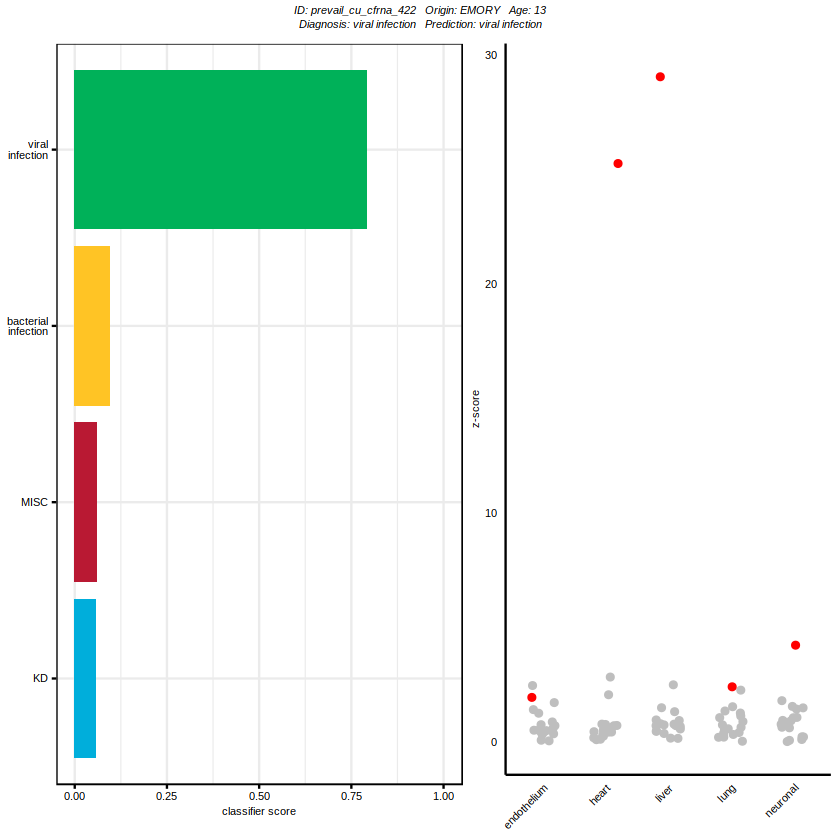

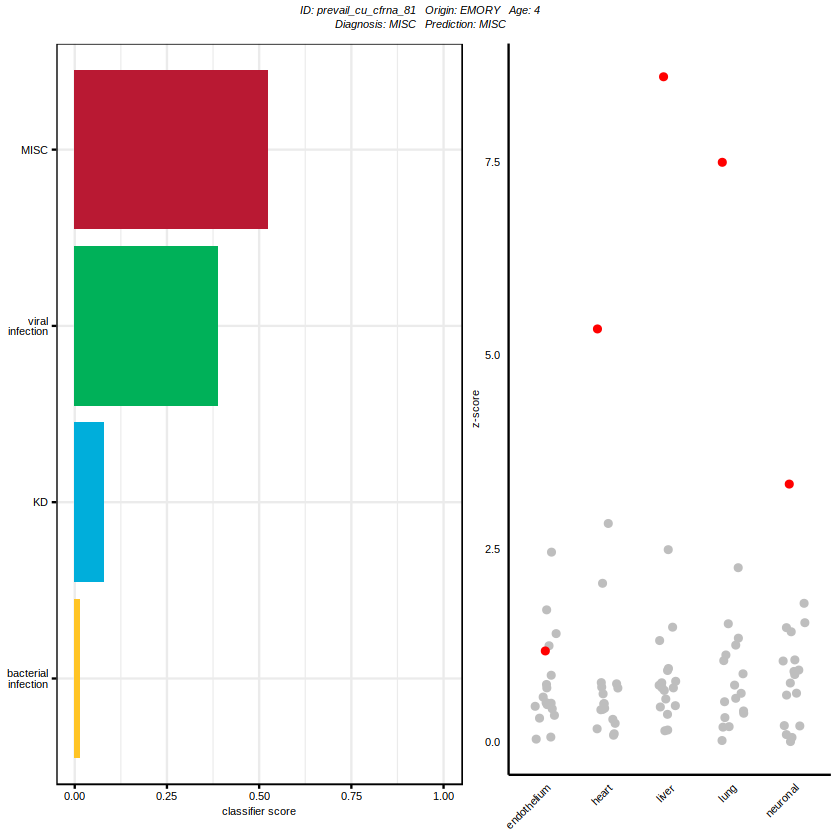

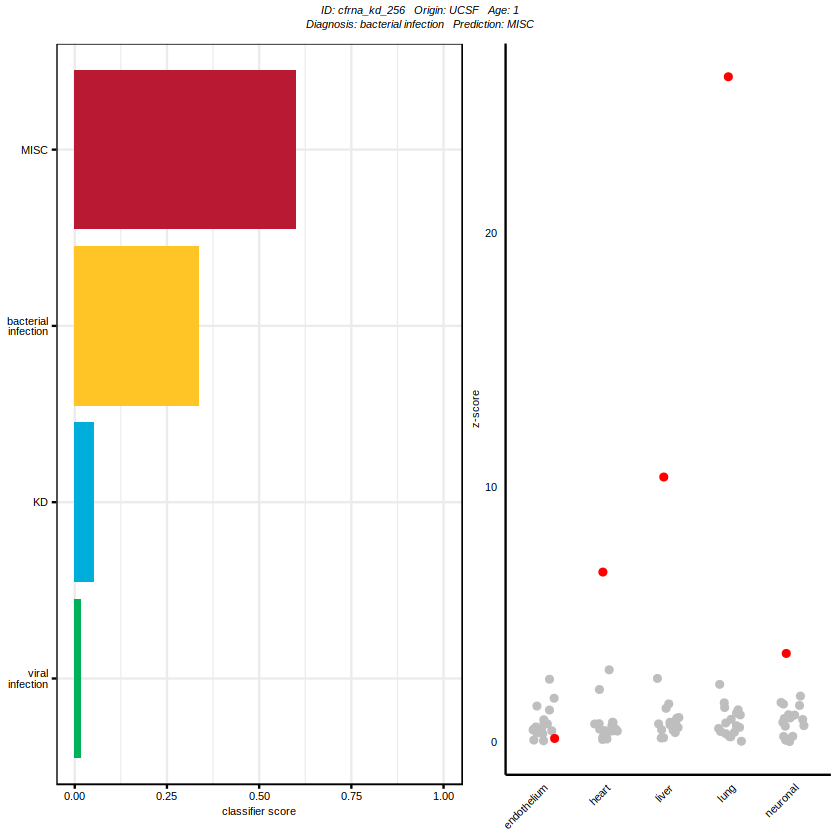

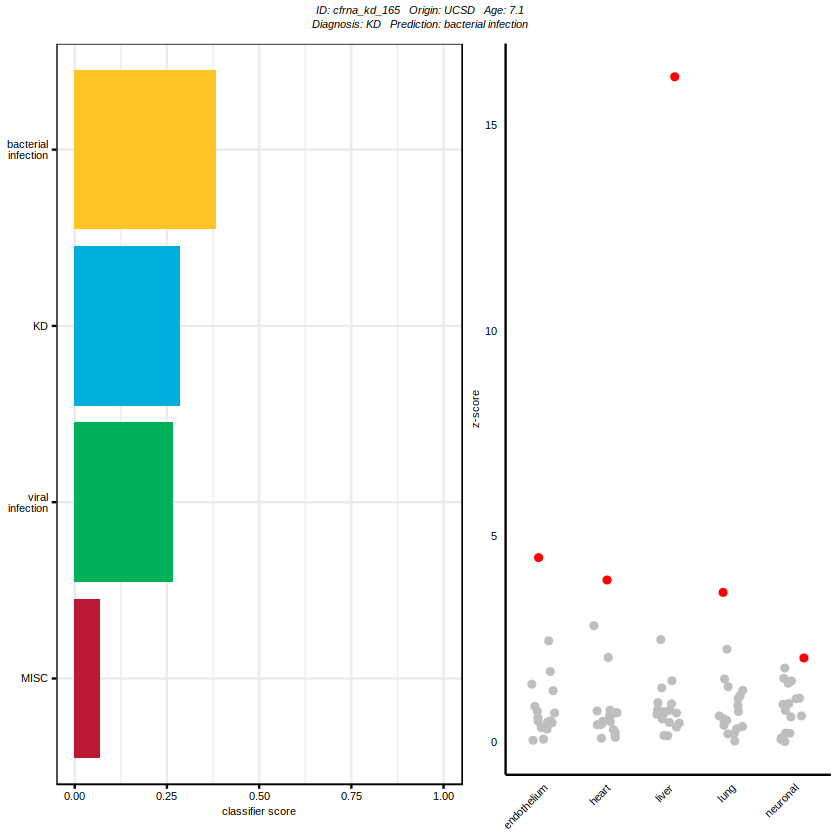

In [11]:
WIDTH = 3
HEIGHT = 1.75
# nCOV3027CHOA
ROW_samp = multiclass_outputs %>% filter(PTID == "NCOV3027CHOA") 
plt <- make_CDST(ROW_samp,multiclass_res,meta_redcap_plt,FALSE)
grid.arrange(plt)
ggsave("./plots/ALL_vignette-CASE1.pdf", plt, width = WIDTH, height = HEIGHT, units = "in")


# nCoV3291CHOA
ROW_samp = multiclass_outputs %>% filter(PTID == "NCOV3291CHOA")
plt <- make_CDST(ROW_samp,multiclass_res,meta_redcap_plt,FALSE)
grid.arrange(plt)
ggsave("./plots/ALL_vignette-CASE2.pdf", plt, width = WIDTH, height = HEIGHT, units = "in")


# SEP1056
ROW_samp = multiclass_outputs %>% filter(PTID == "SEP0156")
plt <- make_CDST(ROW_samp,multiclass_res,meta_redcap_plt,FALSE)
grid.arrange(plt)
ggsave("./plots/ALL_vignette-CASE3.pdf", plt, width = WIDTH, height = HEIGHT, units = "in")


# SEP0581
ROW_samp = multiclass_outputs %>% filter(PTID == "213053")
plt <- make_CDST(ROW_samp,multiclass_res,meta_redcap_plt,FALSE)
grid.arrange(plt)
ggsave("./plots/ALL_vignette-CASE4.pdf", plt, width = WIDTH, height = HEIGHT, units = "in")
